In [1]:
# See http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.105.1166&rep=rep1&type=pdf for clarification
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class Point:
    
    def __repr__(self):
        return f'Point({self.x})'
    
    def __init__(self, x):
        self.x = x
        self.dim = len(x)

class DirichletControlPoint(Point):
    
    def __repr__(self):
        return f'DirichletControlPoint({self.x}, val={self.val})'
    
    def __init__(self, x, val):
        super().__init__(x)
        self.val = val

class TargetPoint(Point):
    
    def __repr__(self):
        return f'TargetPoint({self.x})'
    
    def __init__(self, x):
        super().__init__(x)

In [3]:
square_control_points = []
for i in np.linspace(0, 1, 11):
    square_control_points.append(DirichletControlPoint(x=(0, i), val=0))
for i in np.linspace(0, 1, 11):
    square_control_points.append(DirichletControlPoint(x=(1, i), val=0))
for i in np.linspace(1, 0, 11):
    square_control_points.append(DirichletControlPoint(x=(i, 0), val=0))
for i in np.linspace(0, 1, 11):
    square_control_points.append(DirichletControlPoint(x=(i, 1), val=0))

In [4]:
square_control_points[:5]

[DirichletControlPoint((0, 0.0), val=0),
 DirichletControlPoint((0, 0.1), val=0),
 DirichletControlPoint((0, 0.2), val=0),
 DirichletControlPoint((0, 0.30000000000000004), val=0),
 DirichletControlPoint((0, 0.4), val=0)]

In [5]:
def create_mapping_targets(control_points, center, r=0.5):
    
    # remove the control points that are defined more than once
    coords = set()
    unique = []
    for cp in control_points:
        if cp.x not in coords:
            coords.add(cp.x)
            unique.append(cp)
    
    # sort the control points 'clockwise' (from 0 to -2pi)
    def clockwise(cp):
        return (
            1 if cp.x[1]-center[1] > 0 else -1,
            (cp.x[0]-center[0])/(cp.x[1]-center[1]-1e-8)
        )
    control_points = sorted(unique, key=clockwise)

    # create equally spaced target points
    target_points = [
        TargetPoint( (r*np.cos(theta), r*np.sin(theta)) )
        for theta in -np.linspace(0, 2*np.pi, len(control_points), endpoint=False)
    ]
    
    assert len(control_points) == len(target_points)
    return control_points, target_points

In [6]:
control_points, target_points = create_mapping_targets(square_control_points, (0.5, 0.5))

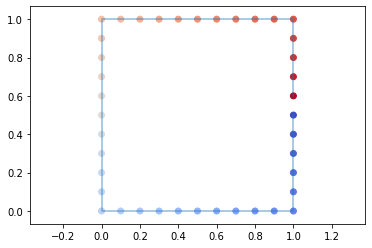

In [7]:
xs = [cp.x[0] for cp in control_points]
ys = [cp.x[1] for cp in control_points]
plt.plot(xs, ys, alpha=0.5)
plt.scatter(xs, ys, c=range(len(xs)), cmap='coolwarm')
plt.axis('equal');

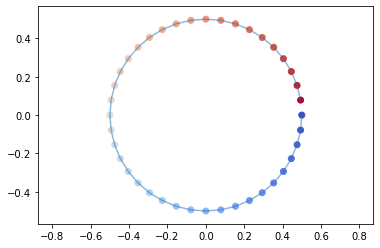

In [8]:
xs = [tp.x[0] for tp in target_points]
ys = [tp.x[1] for tp in target_points]
plt.plot(xs, ys, alpha=0.5)
plt.scatter(xs, ys, c=range(len(xs)), cmap='coolwarm')
plt.axis('equal');

In [9]:
def distance(p, cp, stiffness=0.01):
    return np.sqrt(
        sum((d_p-d_cp)**2 for d_p, d_cp in zip(p.x, cp.x)) 
        + stiffness**2
    )

In [10]:
def solve_tps(control_points, targets):
    n_dims = control_points[0].dim
    n_pnts = len(control_points)
    n_eqts = n_coef = n_dims+n_pnts+1
    
    def equation_weights(equation_no):    
        weights = np.zeros(n_coef)
        if equation_no < n_pnts:
            p = control_points[equation_no]
            for i in range(n_pnts):
                r = distance(p, control_points[i])
                weights[i] = r**2 * np.log(r**2)
            weights[n_pnts] = 1.0
            for i in range(n_dims):
                weights[n_pnts+1+i] = p.x[i]
        elif equation_no <  n_pnts + n_dims:
            j_dim = equation_no - n_pnts
            for i in range(n_pnts):
                weights[i] = control_points[i].x[j_dim]
        elif equation_no == n_pnts + n_dims:
            weights[:n_pnts] = 1.0
        return weights
    
    W = np.zeros((n_eqts, n_coef))
    
    for equation_no in range(n_eqts):
        W[equation_no] = equation_weights(equation_no)
    b = np.zeros(n_eqts)
    b[:n_pnts] = targets
    return np.linalg.solve(W, b)

In [11]:
def create_mapping(control_points, target_points):
    coefs_of_dim = [
        solve_tps(control_points, np.array([tp.x[i] for tp in target_points]))
        for i in range(target_points[0].dim)
    ]    
    n_dims = control_points[0].dim
    n_pnts = len(control_points)
    n_eqts = n_coef = n_dims+n_pnts+1
    
    def map_by_tps(p):
        
        def map_dim(i):
            dim_i_mapped = 0.0
            for coef, cp in zip(coefs_of_dim[i], control_points): # coef: first len(control_points) weights
                r = distance(p, control_points[i])
                dim_i_mapped += coef * r**2 * np.log(r**2)
            dim_i_mapped += coefs_of_dim[i][n_pnts]
            for j_dim in range(p.dim):
                dim_i_mapped += coefs_of_dim[i][n_pnts+1+j_dim] * p.x[i]
            return dim_i_mapped
        
        return Point(x=tuple(map_dim(i) for i in range(p.dim)))
    
    return map_by_tps

In [12]:
mapping = create_mapping(control_points, target_points)

In [13]:
mapping(Point(x=(0.0, 0.0)))

Point((-0.30505309294741917, -0.3050530929474198))

In [14]:
def L_D(p, r=0.5, mapping=None):
    if mapping:
        return r**2 - sum(d**2 for d in mapping(p).x)
    else:
        return r**2 - sum(d**2 for d in p.x)

In [15]:
xs = np.linspace(0, 1, 101)
ys = np.linspace(0, 1, 101)
xx, yy = np.meshgrid(xs, ys)
points = [Point(x=(dim0, dim1)) for dim0, dim1 in zip(xx, yy)]
lds = [L_D(p, r=0.5, mapping=mapping) for p in points]

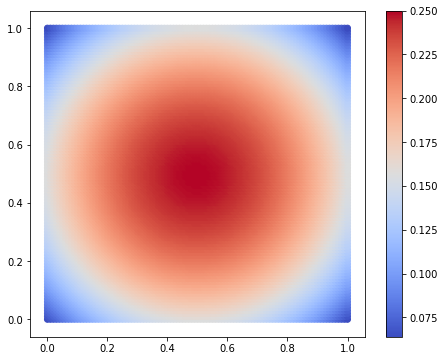

In [16]:
fig, ax = plt.subplots(figsize=(7.5, 6))
cs = ax.scatter(xx, yy, c=lds, cmap='coolwarm')
cbar = fig.colorbar(cs)

In [17]:
control_points[5], target_points[5], mapping(control_points[5])

(DirichletControlPoint((1, 0.0), val=0),
 TargetPoint((0.3535533905932738, -0.35355339059327373)),
 Point((0.3050530929474188, -0.30505309294741967)))

In [18]:
control_points[10], target_points[10], mapping(control_points[5])

(DirichletControlPoint((0.5, 0), val=0),
 TargetPoint((3.061616997868383e-17, -0.5)),
 Point((0.3050530929474188, -0.30505309294741967)))

In [19]:
# something went wrong in the TPS fitting